In [7]:
!python --version

Python 3.7.10


# Sentiment Analysis 
(A Project done through Udacity)

Sentiment analysis (aka opnion mining) is an nlp technique used to determine whether the given data is positive, negative (or neutral). In the following section, a sentiment analysis will be peformed on IMDb data using a basic classifier.


## Step 1: Exploring the data

I am going to usethe [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/). It consists of movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either '**pos**itive', if the reviewer enjoyed the film, or '**neg**ative' otherwise.

Reference:
> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.

After loading the data set, I will create two dictionaries based on the directories in the data set: One dictionary for data and the other for labels (positive vs. negative).

In [1]:
!pip install beautifulsoup4

import os

import glob

def read_imdb_data(data_dir='data/imdb-reviews'):
    """Read IMDb movie reviews from given directory.
    
    Directory structure expected:
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    
    """

    # NESTED DICTIONARIES: Data, labels to be returned in nested dicts matching the dir. structure
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign labels
            for f in files:
                # Add-on Fix Encoding UTF-8
                with open(f, encoding="utf-8") as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts
    return data, labels


data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


Now that the data is loaded in, let's take a quick look at one of the positive reviews:

In [2]:
print(data['train']['pos'][2])

A solid, if unremarkable film. Matthau, as Einstein, was wonderful. My favorite part, and the only thing that would make me go out of my way to see this again, was the wonderful scene with the physicists playing badmitton, I loved the sweaters and the conversation while they waited for Robbins to retrieve the birdie.


And one with a negative sentiment:

In [3]:
print(data['train']['neg'][2])

Ouch! This one was a bit painful to sit through. It has a cute and amusing premise, but it all goes to hell from there. Matthew Modine is almost always pedestrian and annoying, and he does not disappoint in this one. Deborah Kara Unger and John Neville turned in surprisingly decent performances. Alan Bates and Jennifer Tilly, among others, played it way over the top. I know that's the way the parts were written, and it's hard to blame actors, when the script and director have them do such schlock. If you're going to have outrageous characters, that's OK, but you gotta have good material to make it work. It didn't here. Run away screaming from this movie if at all possible.


We can also make a wordcloud visualization of the reviews.

In [4]:
# Installing wordcloud
!pip install wordcloud

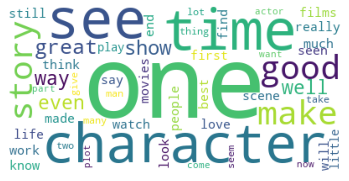

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 
# Displaying plots immediately after the current cell

from wordcloud import WordCloud, STOPWORDS

sentiment = 'pos'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(['br','film','movie']))
                                     # Also js script tag "br"
# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

Now changing the sentiment to `'neg'` and see if you can spot any obvious differences between the wordclouds.

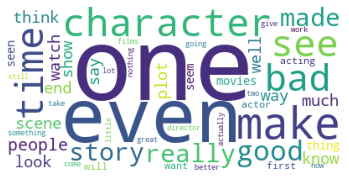

In [6]:
sentiment = 'neg'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(['br','film','movie']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

### Form training and test sets

Since we're done seeing what the raw data look like, let's combine the positive and negative documents to get one unified training set and one unified test set.

In [7]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):
    """Prepare training and test sets from IMDb movie reviews."""
    
    # Combine positive and negative reviews and labels
    data_train_ = data['train']['pos'] + data['train']['neg']
    data_test_ = data['test']['pos'] + data['test']['neg']
    labels_train_ = labels['train']['pos'] + labels['train']['neg']
    labels_test_ = labels['test']['pos'] + labels['test']['neg']
    
    # Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train_, labels_train_)
    data_test, labels_test = shuffle(data_test_, labels_test_)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test


data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


## Step 2. Preprocessing

The samples in the given dataset include HTML. Therefore there are HTML tags that need to be removed. It's also needed to remove non-letter characters, normalize uppercase letters by converting them to lowercase, tokenize, remove stop words, and stem the remaining words in each document.

In [8]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup 

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sohyepark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    
    text = BeautifulSoup(review, "html5lib").get_text()
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]", ' ', text)
    words = [ word for word in text.split(' ') if word not in stopwords.words("english") ]
    words = [stemmer.stem(word) for word in words]

    # Return final list of words
    return words

In [10]:
# Check whether the text processing function works well.
review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

['test', '', 'test', '', 'would', 'make', 'great', 'movi', 'review', '']

Let's apply the  `review_to_words()` created above to all reviews in both training and test datasets. This may take a while, so let's build in a mechanism to write to a cache file and retrieve from it later.

In [12]:
import pickle
# Pickle module is used for storing numpy arrays (cf. advanced ver: joblib)
# Python pickle files may have the extension ". pickle" or ". pkl". 
# A Python pickle file serializes a tuple of two numpy arrays, (feature, label). There is no notion of "sentences" in pickle files; in other words, a pickle files stores exactly one sentence.

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting (Important part!)
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test



In [13]:
# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Read preprocessed data from cache file: preprocessed_data.pkl

--- Raw review ---
BASEketball is awesome! It's hilarious and so damned funny that you will wet your pants laughing. I have seen it so many times I have stopped counting. But everytime it gets funnier.<br /><br />Trust me on this one...BASEketball is a surefire hit and I loved it and will continue to love it. I hope one day there will be a special edition DVD brought out!!!<br /><br />Ten Thumbs Up!!!

--- Preprocessed words ---
['weird', '', 'witti', 'wonder', 'depict', 'famili', 'life', '', 'writer', 'andrew', 'marshal', 'written', 'someth', 'funni', '', 'forebod', 'occasion', 'frighten', '', 'ye', '', 'fool', '2point4', 'children', 'cheer', 'tune', 'bubbl', 'charact', '', 'show', 'dark', 'side', '', 'time', 'quit', 'chill', '', 'good', 'show', '', 'simplist', 'sitcom', 'everi', 'charact', '2d', 'comic', 'devic', '', 'case', 'famili', '', '', 'instead', 'charact', 'fulli', 'round', 'individu', 'show', 'full', 'roller', 'c

## Step 3: Extracting Bag-of-Words features

Now that each document has been preprocessed, I will transform each into a **Bag-of-Words** feature representation. Note that we need to create this transformation based on the training data alone, not the test data.

The dictionary or _vocabulary_ $V$ (set of words shared by documents in the training set) used here will be the one on which we train our supervised learning algorithm. Any future test data must be transformed in the same way for us to be able to apply the learned model for prediction. Hence, it is important to store the transformation / vocabulary as well.

> **Note**: What about a word encountered during testing that you haven't seen before? Unfortunately, we'll have to ignore it, or replace it with a special `<UNK>` token.

### Compute Bag-of-Words features

Implement the `extract_BoW_features()` function, apply it to both training and test datasets, and store the results in `features_train` and `features_test` NumPy arrays, respectively. Choose a reasonable vocabulary size, say $|V| = 5000$, and keep only the top $|V|$ occuring words and discard the rest (Frequency matters!). This number will also serve as the number of columns in the BoW matrices.


In [14]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.externals import joblib --> caused error message
import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(preprocessor=lambda x: x, 
                                     tokenizer=lambda x: x,  
                                     max_features=vocabulary_size)
        features_train = vectorizer.fit_transform(words_train).toarray()

        # Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.transform(words_test).toarray()
                # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary


# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Read features from cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['aunt', 'store', '1985', 'intent', 'darren', '25', 'traci', 'restrict']

--- Preprocessed words ---
['somewher', '', 'site', '', 'someon', 'wrote', 'get', 'best', 'version', 'work', 'jane', 'austen', '', 'one', 'simpli', 'read', '', 'agre', '', 'howev', '', 'love', 'adapt', 'great', 'literatur', 'current', 'writer', '', 'strike', 'bring', 'mind', 'without', 'good', 'writer', '', 'hard', 'actor', 'bring', 'role', 'life', '', 'current', 'version', 'jane', 'austen', 'persuas', 'show', 'us', 'happen', 'good', 'foundat', 'well', 'written', 'adapt', '', 'version', 'compar', '1995', 'version', 'amanda', 'root', 'ciaran', 'hind', '', 'well', 'act', 'kept', 'essenc', 'era', 'constraint', 'charact', '', 'except', 'bizarr', 'parad', '', '', 'kiss', 'street', 'scene', 'bath', '', '', '2007', 'version', 'show', 'twitti', 'ann', 'seem', 'angst', 'ridden', '', 'charact', 'develop', 'crime', '', 'consid', 'austen', '

Let's try to visualize the Bag-of-Words feature vector for one of our training documents.

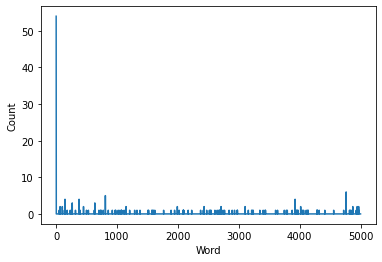

In [15]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()


As expected, the example BoW vector shows sparsity. 

### Zipf's law (Linguistics concept)

[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), named after the famous American linguist George Zipf, is an empirical law stating that given a large collection of documents, the frequency of any word is inversely proportional to its rank in the frequency table. So the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, and so on. In the figure below we plot number of appearances of each word in our training set against its rank.

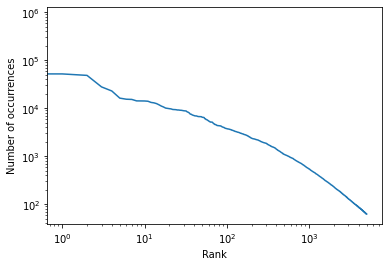

In [16]:
# Find number of occurrences for each word in the training set (column sum)
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

The total number of occurrences of the most frequent word is close to 10^5. In general, the plot above shows the pattern described by Zipf's law.

### Normalize feature vectors

Bag-of-Words features are intuitive to understand as they are simply word counts. But counts can vary a lot, and potentially throw off learning algorithms later in the pipeline. So, before we proceed further, let's normalize the BoW feature vectors to have unit length.

This makes sure that each document's representation retains the unique mixture of feature components, but prevents documents with large word counts from dominating those with fewer words.

In [17]:
import sklearn.preprocessing as pr

# Normalize BoW features in training and test set
features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

features_train[0]

array([0.94329996, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

## Step 4: Classification using BoW features

Now that the data has all been properly transformed, we can feed it into a classifier. To get a baseline model, I will train a Naive Bayes classifier from scikit-learn (specifically, [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)), and evaluate its accuracy on the test set.

In [18]:
from sklearn.naive_bayes import GaussianNB

# Train a Guassian Naive Bayes classifier
clf1 = GaussianNB()
clf1.fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.789, test = 0.68924


Tree-based algorithms often work quite well on Bag-of-Words as their highly discontinuous and sparse nature is nicely matched by the structure of trees. In the following section, I will try improving on the Naive Bayes classifier's performance by using scikit-learn's Gradient-Boosted Decision Tree classifer.

### Gradient-Boosted Decision Tree classifier

Use [`GradientBoostingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) from scikit-learn to classify the BoW data. This model has a number of parameters. I used default parameters for some of them, except one: `n_estimators`. I played with it to find a proper value for this hyperparameter, using it to classify the data and finding out how much improvement you get over Naive Bayes in terms of accuracy.

> **How to find the best n_estimators**: A model selection technique such as cross-validation, grid-search, or an information criterion method, was used to find an optimal value for the hyperparameter.

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 50

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=0)

    clf.fit(X_train, y_train) #Classify the data using the GBDT.
       
    # Print final training & test accuracy
    print("[{}] Accuracy: train = {:.4f}, test = {:.4f}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))
    
    # Return best classifier model
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

[GradientBoostingClassifier] Accuracy: train = 0.8186, test = 0.8113


### Adverserial testing

I wrote a short movie review to trick my machine learning model. This review contains a clear positive or negative sentiment that your model will classify incorrectly.


In [20]:
# Write a sample review and set its true sentiment
my_review = "At first, I thought it would be awfull and boring, but it was not that bad. Pass the first long 20 minutes"
true_sentiment = 'pos'  # sentiment must be 'pos' or 'neg'

my_review = "I thought it would be just like all the other boring sequels that are coming out everyday. But had I not gone, I would've missed out on a treat. Not only was it not boring, it kept me at the edge of my seat till the end."
true_sentiment = 'pos'  # sentiment must be 'pos' or 'neg'

# Apply the same preprocessing and vectorizing steps as you did for your training data
my_words = review_to_words(my_review)
vectorizer = CountVectorizer(vocabulary=vocabulary,
                             preprocessor=lambda x: x, tokenizer=lambda x: x) 
my_bow_features = vectorizer.transform([my_words]).toarray() 

print("Predicted sentiment", clf2.predict(my_bow_features)[0], "True sentiment",true_sentiment )


# Then call your classifier to label it


Predicted sentiment neg True sentiment pos
